#Plot of illumination as a funtion of transit time

Discussing improvements to the paper with Pete

* "Absolute flux" version of the 4 panel plot to highlight the impact of moving through the stellar line profile
* Literature review again - check exactly what it was the Geneva paper (and others) say about the depth of the line profile in relation to atmosphere planetary depth
* New "plot 1" possibly including the transit schematic. How does the illumination of the planet change as a function of time. Also split by hemisphere.

# Setup

In [1]:
%load_ext autoreload
%autoreload 1
%aimport two_sides_figure
%aimport elements_model3d
%aimport model3d

pf = two_sides_figure
m3d = elements_model3d
old_m3d = model3d


import os
import pickle
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt


dir = 'everything/'
files = os.listdir(dir)

sodium_d = [5889.950,5895.924]

time = []
wvl = []
spectra = []
spectra_errors = []
spectra2 = []
spectra_errors2 = []

min_wvl = 5869
max_wvl = 5909

for f in files:
  time += [float(f[:-3])]
  data = pickle.load(open(dir+f,'rb'))
  index = [(data['wvl'] > min_wvl) & (data['wvl'] < max_wvl)]

  wvl += [data['wvl'][index]]
  spectra += [data['spec'][index]]
  spectra_errors += [data['spec_error'][index]]

wvl = wvl[0]
time = np.array(time)
spectra = np.array(spectra)
spectra_errors = np.array(spectra_errors)

planet_K = 154
sodium_d = [5889.950,5895.924]
midtransit = 54341.056842
period =  2.21857312
planet_K = 154
star_K = 0.20196
line_centers = sodium_d
plotting = False
nproc = 4
best_fit=False
save_star = False

i1 = 9
i2 = 29


spectra = spectra[np.argsort(time)]
spectra = spectra[np.arange(i1,i2)]

spectra_errors = spectra_errors[np.argsort(time)]
spectra_errors = spectra_errors[np.arange(i1,i2)]

time = time[np.argsort(time)]
time = time[np.arange(i1,i2)]

new_errors = np.array([np.std(spectra, axis=0)]*20)

spectra_errors = new_errors

load = True
save = True
save_m1 = 'test1.p'
save_m2 = 'test2.p'

In [2]:
x1 = [0.51374991, 0.18869174, 8.5049162065200008, -0.15442891679199999,  0.23553298503299999, 0.063145416345300007, -3.50757872893e+50, 111.002838225]

In [3]:
full_model = old_m3d.model_3d(x1,time,period,planet_K,star_K,midtransit,wvl,line_centers,plotting,nproc=nproc,best_fit=best_fit,save_star=save_star,star_vsini=3.1)

In [4]:
import astropy.constants as const

c = const.c.value/1000

star_vel = -2.3

delta_wvl = wvl
star_sodium1 = sodium_d[0]

star_sodium1 += star_vel*sodium_d[0]/c

delta_wvl = wvl - star_sodium1

v = c*delta_wvl/wvl

star_sodium2 = sodium_d[1]

star_sodium2 += star_vel*sodium_d[1]/c

delta_wvl2 = wvl - star_sodium2

v2 = c*delta_wvl2/wvl
master_dat = np.loadtxt('sodium_spectrum.dat')
master_wvl = master_dat[:,0]
master_flux = master_dat[:,1]

master_flux = master_flux/np.median(master_flux)

delta_wvlm = master_wvl - star_sodium1
vm = c*delta_wvlm/master_wvl

delta_wvlm2 = master_wvl - star_sodium2
vm2 = c*delta_wvlm2/master_wvl

In [5]:
master_dat = np.loadtxt('sodium_spectrum.dat')
master_wvl = master_dat[:,0]
master_flux = master_dat[:,1]

master_flux = master_flux/np.median(master_flux)

delta_wvlm = master_wvl - star_sodium1
vm = c*delta_wvlm/master_wvl

delta_wvlm2 = master_wvl - star_sodium2
vm2 = c*delta_wvlm2/master_wvl

In [6]:
midtransit = 54341.056842
period =  2.21857312
planet_K = 154

vel_model = -1*1000*planet_K*np.sin(2.0*np.pi*(midtransit-time)/period)


In [7]:
from spec_manip import align_spectra
from plot_spectrum import bin_curve

scale = np.sqrt(3.0)
resamp_factor = 10

alligned = align_spectra(wvl,spectra.copy(),vel_model)

bin_wvl, bin_alligned, bin_alligned_error = bin_curve(wvl,np.median(alligned,axis=0),scale*np.std(alligned,axis=0)/np.sqrt(len(spectra)),resamp_factor)

alligned_model = align_spectra(wvl,full_model.copy(),vel_model)

alligned_profile = np.mean(alligned_model,axis=0)


In [8]:
star_sodium = sodium_d[0]
star_sodium += star_vel*sodium_d[0]/c
delta_wvl = bin_wvl - star_sodium

bin_v = c*delta_wvl/bin_wvl

star_sodium2 = sodium_d[1]
star_sodium2 += star_vel*sodium_d[1]/c
delta_wvl2 = bin_wvl - star_sodium2

bin_v2 = c*delta_wvl2/bin_wvl

#Illumination plot

How exactly do we want this done? It's the illumination at the wavelength corresponding to *Zero velocity for the planet* at each stage. Will have to interact with elements_vel_prism for this.

Perhaps make a new function instead of hacking together some old stuff? don't actually need to do the transit at each stage after all, only care about the star illumination and vel model.

These will be plots of the relative flux from the star *at the planets rest wavelength of sodium* as a function of time.

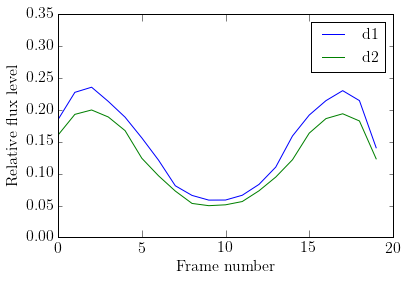

In [9]:
star_vsini=3.1
absolute = False
results = m3d.illumination_model(x1,time,period,planet_K,star_K,midtransit,wvl,line_centers,plotting,nproc=nproc,best_fit=best_fit,save_star=save_star,star_vsini=star_vsini,location='full',absolute=absolute)
our_wvl = results[0]
background_d1 = results[1]
background_d2 = results[2]
plt.plot(background_d1,label='d1')
plt.plot(background_d2,label='d2')
plt.ylabel('Relative flux level')
plt.xlabel('Frame number')
plt.ylim(0,0.35)
plt.legend()
plt.show()

Looks interesting, ingress/egress are brighter than mid transit! For sake of comparison, how does it look if the star is spinning retrograde?

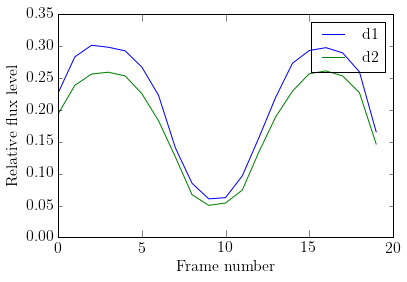

In [10]:
star_vsini=-3.1
absolute = False
results = m3d.illumination_model(x1,time,period,planet_K,star_K,midtransit,wvl,line_centers,plotting,nproc=nproc,best_fit=best_fit,save_star=save_star,star_vsini=star_vsini,location='full',absolute=absolute)
our_wvl = results[0]
background_d1 = results[1]
background_d2 = results[2]
plt.plot(background_d1,label='d1')
plt.plot(background_d2,label='d2')
plt.ylabel('Relative flux level')
plt.xlabel('Frame number')
plt.ylim(0,0.35)
plt.legend()
plt.show()

That seems about right, the additional velocity discrepency between planet and surface makes the effect larger. That would make a non-rotating star somewhere in the middle:

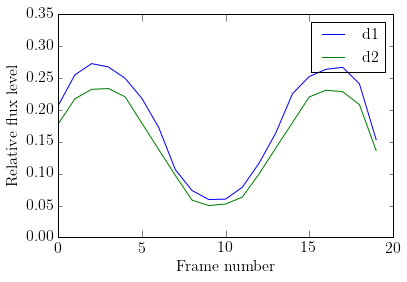

In [11]:
star_vsini=0.0
absolute = False
results = m3d.illumination_model(x1,time,period,planet_K,star_K,midtransit,wvl,line_centers,plotting,nproc=nproc,best_fit=best_fit,save_star=save_star,star_vsini=star_vsini,location='full',absolute=absolute)
our_wvl = results[0]
background_d1 = results[1]
background_d2 = results[2]
plt.plot(background_d1,label='d1')
plt.plot(background_d2,label='d2')
plt.ylabel('Relative flux level')
plt.xlabel('Frame number')
plt.ylim(0,0.35)
plt.legend()
plt.show()

Yep!

Might also be nice to have a plot of what the velocity of ther planet and star are doing.

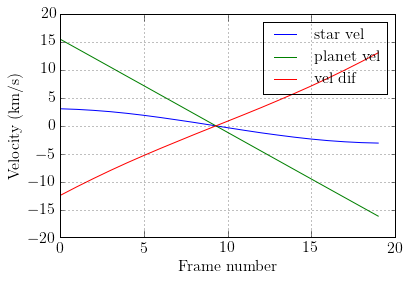

In [13]:
star_vsini=3.1
absolute = False
results = m3d.illumination_model(x1,time,period,planet_K,star_K,midtransit,wvl,line_centers,plotting,nproc=nproc,best_fit=best_fit,save_star=save_star,star_vsini=star_vsini,location='full',absolute=absolute)
our_wvl = results[0]
background_d1 = results[1]
background_d2 = results[2]
star_vel = results[3]
vel_model = results[4]

plt.plot(star_vel,label='star vel')
plt.plot(vel_model,label='planet vel')
plt.plot(star_vel-vel_model,label='vel dif')
plt.legend()
plt.ylabel('Velocity (km/s)')
plt.xlabel('Frame number')
plt.grid()
plt.show()

It's still not obvious what's going on... we need to go deeper. Look at the individual shifted spectra and where your zero point ends up on each one.

#Examine spectra

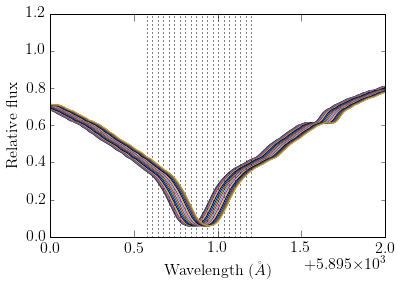

In [14]:
star_vsini=3.1
absolute = False
results = m3d.illumination_model(x1,time,period,planet_K,star_K,midtransit,wvl,line_centers,plotting,nproc=nproc,best_fit=best_fit,save_star=save_star,star_vsini=star_vsini,location='full',absolute=absolute)
our_wvl = results[0]
background_d1 = results[1]
background_d2 = results[2]
star_vel = results[3]
vel_model = results[4]
shifted_d1 = results[5]
shifted_spectra = results[6]

#plt.plot(our_wvl,shifted_spectra[9])
#plt.axvline(shifted_d1[9],color='k',ls=':')
#plt.xlim(5895,5897)
#plt.show()

for n in range(0,len(shifted_d1)):
    plt.plot(our_wvl,shifted_spectra[n]/np.median(shifted_spectra[0]))
    plt.axvline(shifted_d1[n],color='k',ls=':')
    plt.xlim(5895,5897)

plt.ylabel('Relative flux')
plt.xlabel('Wavelength ($\AA$)')
plt.show()

#Plot with two sides

A useful thing to have would be the same plot but split between left hemisphere and right hemisphere. this should only require a small addition to the code.

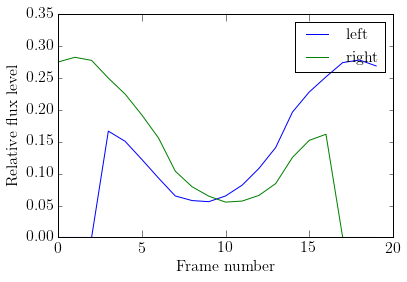

In [15]:
star_vsini=3.1
absolute = False

results_left = m3d.illumination_model(x1,time,period,planet_K,star_K,midtransit,wvl,line_centers,plotting,nproc=nproc,best_fit=best_fit,save_star=save_star,star_vsini=star_vsini,location='left',absolute=absolute)
results_right = m3d.illumination_model(x1,time,period,planet_K,star_K,midtransit,wvl,line_centers,plotting,nproc=nproc,best_fit=best_fit,save_star=save_star,star_vsini=star_vsini,location='right',absolute=absolute)

our_wvl = results[0]
left_d1 = results_left[1]
right_d1 = results_right[1]

plt.plot(left_d1,label='left')
plt.plot(right_d1,label='right')
plt.ylabel('Relative flux level')
plt.xlabel('Frame number')
plt.ylim(0,0.35)
plt.legend()
plt.show()

Excellent! Let's do that with phase instead of Frame number.

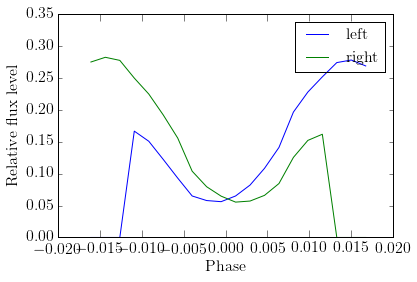

In [16]:
phase = (time - midtransit)/period

plt.plot(phase,left_d1,label='left')
plt.plot(phase,right_d1,label='right')
plt.ylabel('Relative flux level')
plt.xlabel('Phase')
plt.ylim(0,0.35)
plt.legend()
plt.show()

Nice! Now let's smooth that out a bit by adding more points...

In [17]:
star_vsini=3.1
absolute = False


npoints = 300
new_time = np.linspace(min(time),max(time),npoints)

new_phase = (new_time - midtransit)/period

results_left = m3d.illumination_model(x1,new_time,period,planet_K,star_K,midtransit,wvl,line_centers,plotting,nproc=nproc,best_fit=best_fit,save_star=save_star,star_vsini=star_vsini,location='left',absolute=absolute)
results_right = m3d.illumination_model(x1,new_time,period,planet_K,star_K,midtransit,wvl,line_centers,plotting,nproc=nproc,best_fit=best_fit,save_star=save_star,star_vsini=star_vsini,location='right',absolute=absolute)

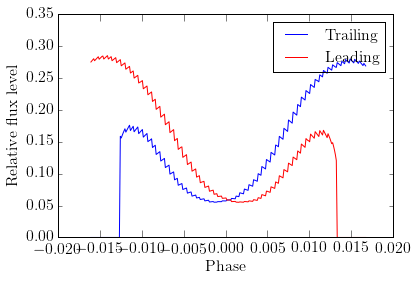

In [18]:
our_wvl = results[0]
left_d1 = results_left[1]
right_d1 = results_right[1]

plt.plot(new_phase,left_d1,label='Trailing',color=(0,0,1))
plt.plot(new_phase,right_d1,label='Leading',color=(1,0,0))
plt.ylabel('Relative flux level')
plt.xlabel('Phase')
plt.ylim(0,0.35)
plt.legend()
plt.show()

# Final plot

OK, that's actually quite a nice looking plot, I think. It would look a lot better with higher resolution. The trick to that is probably going to be either a fit or some sort of interpolation/smoothing. This is fine, since it's a demonstration of the model and not presenting quantitative results.

It shows quite clearly that there's actually more flux during ingress/egress due to the dimming of the planet's zero velocity point passing through the center of the sodium lines